In [ ]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from utils import RegisterConverter
import nltk
from nltk.tokenize import TweetTokenizer
from collections import Counter
from nltk.corpus import stopwords  
import preprocessor as p

In [ ]:
syn_file = 'syn_file.csv'
class_file = "AllWordsClassified.csv"
converter = RegisterConverter(class_file, syn_file, open('vocabulary.txt', "r", encoding="utf8"))

In [3]:
data_complaint = pd.read_csv('complaint1700.csv')
data_complaint['label'] = 1
data_non_complaint = pd.read_csv('noncomplaint1700.csv')
data_non_complaint['label'] = 0

data_df = pd.concat([data_complaint, data_non_complaint], axis=0).reset_index(drop=True)

data_df.drop(['airline'], inplace=True, axis=1)

In [4]:
data_df

,id,tweet,label
0,80938,@united I'm having issues. Yesterday I rebooke...,1
1,10959,@united kinda feel like the $6.99 you charge f...,1
2,130813,"Livid in Vegas, delayed, again&amp; again&amp;...",1
3,146589,@united the most annoying man on earth is on m...,1
4,117579,"@united The last 2 weeks I've flown wit u, you...",1
...,...,...,...
3395,171958,@SubTheGamer @united completely pathetic! I'm ...,0
3396,172278,@QuranWeekly @united Too many bigots in Ameri...,0
3397,172327,@SangyeH @united I would too. My sister conver...,0
3398,172403,Ã¢â‚¬Å“@hindukid1021: prime example of our wor...,0


In [5]:
tknzr = TweetTokenizer()
all_words = []
for sentence in data_df["tweet"]:
    s = p.clean(sentence)
    s = re.sub(r'[^\w\s]','',s.lower())
    all_words += tknzr.tokenize(s)

bigrams = []
for sentence in data_df["tweet"]:
    s = p.clean(sentence)
    s = re.sub(r'[^\w\s]','',s.lower())
    bigrams += nltk.ngrams(s.split(),2)
    

In [6]:
top = Counter([word  for word in bigrams])
temp = pd.DataFrame(top.most_common(50))
temp.columns = ['Common_bigrams','count']
temp.style.background_gradient(cmap='Blues')

,Common_bigrams,count
0,"('my', 'flight')",173
1,"('on', 'the')",131
2,"('i', 'have')",99
3,"('for', 'the')",93
4,"('in', 'the')",88
5,"('customer', 'service')",86
6,"('cant', 'wait')",84
7,"('flight', 'to')",83
8,"('a', 'flight')",80
9,"('to', 'get')",80


In [7]:
stop_words = set(stopwords.words('english'))
top = Counter([word  for word in all_words if word not in stop_words])
temp = pd.DataFrame(top.most_common(30))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,flight,932
1,never,268
2,get,251
3,delayed,226
4,amp,224
5,wait,209
6,im,208
7,time,179
8,service,173
9,flights,164


In [8]:
from sklearn.model_selection import train_test_split

tweets = data_df.tweet.values
labels = data_df.label.values

train_tweets, test_tweets, train_labels, test_labels = train_test_split(tweets, labels, test_size=0.1)

## Preprocessing

In [9]:
test_tweets_converted = list(map(converter.change_paragraph, test_tweets))















brutal (0.5) --> savage (0.6188477471662273)














funny (0.5) --> amusing (0.556)
















complete (0.333) --> concluded (0.5687188614600799)










domestic (0.444) --> municipal (0.556)












entire (0.333) --> integral (0.556)
















safe (0.333) --> harmless (0.556)


lost (0.5) --> missing (0.667)










sudden (0.389) --> abrupt (0.556)




mechanical (0.5) --> automatic (0.556)




normal (0.389) --> median (0.6223513376162577)












high (0.333) --> utmost (0.556)










constant (0.444) --> perpetual (0.6724829931282803)






final (0.389) --> closing (0.5675759390300961)


extra (0.5) --> additive (0.708698278331351)






terrible (0.389) --> wicked (0.6262631795351533)
















































available (0.444) --> accessible (0.556)


middle (0.444) --> mid (0.5262143544958447)


flat (0.5) --> compressed (0.6662192683657344)


hot (0.333) --> burning (0.556)




consistent (0.389) --> log

In [10]:
weights = [x[1]/len(x[0].split()) for x in test_tweets_converted]
sum_weights = sum(weights)
weights = np.array([x/sum_weights for x in weights])

In [11]:
for i in range(4, 10):
#     print('Original: ', train_tweets[i])
    print('Processed: ', p.clean(train_tweets[i]))
    print('converted: ', converter.change_paragraph(p.clean(train_tweets[i])))
    print("\n")

Processed:  Always a bummer to be delayed on the Tarmac. But hey, safety first and has TV. Also Clueless is on.


converted:  ('Always a bummer to be delayed on the Tarmac. But hey, safety first and has TV. Also Clueless is on.', 0, 0)


Processed:  My flight was delayed times in an hour and now its leaving after midnight and a minute wait to talk to a service rep


converted:  ('My flight was delayed times in an hour and now its leaving after midnight and a minute wait to talk to a service rep', 0, 0)


Processed:  Landed in Midland :30pm Tuesday, took off at :10pm Wednesday. All for a hr meeting. Hell of a commute.


converted:  ('Landed in Midland :30pm Tuesday, took off at :10pm Wednesday. All for a hr meeting. Hell of a commute.', 0, 0)


Processed:  Definitely . They lost my suitcase forever. FOREVER!!!


converted:  ('Definitely. They lost my suitcase forever. FOREVER ! ! !', 0, 0)


Processed:  This is why you suck !!! mins before we are to start boarding you change the fucking

The encode_plus method of BERT tokenizer will:

(1) split our text into tokens,

(2) add the special [CLS] and [SEP] tokens, and

(3) convert these tokens into indexes of the tokenizer vocabulary,

(4) pad or truncate sentences to max length, and

(5) create attention mask.

In [12]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sentence in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=p.clean(sentence),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

find max length of a sentence

In [13]:
# Concatenate train data and test data
all_tweets = data_df.tweet.values

# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  68


In [14]:
MAX_LEN = 68

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([train_tweets[0]])[0].squeeze().numpy())
print('Original: ', train_tweets[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(train_tweets)
test_inputs, test_masks = preprocessing_for_bert(test_tweets)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  With @AirCanada taking away more @ACAltitude benefits, which airline should I switch to in 2015? @AmericanAir? @United? #flyerstalk
Token IDs:  [101, 2007, 2635, 2185, 2062, 6666, 1010, 2029, 8582, 2323, 1045, 6942, 2000, 1999, 1029, 1029, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


/home/liam/anaconda3/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2149: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [15]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

### define our model

In [16]:
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert for Classification Tasks """
    def __init__(self, freeze_bert=False):
        
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

#         self.classifier = nn.Sequential(
#             nn.Linear(D_in, H),
#             nn.ReLU(),
#             #nn.Dropout(0.5),
#             nn.Linear(H, D_out)
#         )
        self.classifier = nn.Linear(D_in, D_out)

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        logits = self.classifier(last_hidden_state_cls)

        return logits

In [39]:
model = BertClassifier(freeze_bert=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
EPOCHS = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [40]:
res_dict = {"train_loss_list":[],"test_loss_list":[],"train_acc_list":[],"test_acc_list":[]}
for epoch in range(EPOCHS):
    print(f"start epoch: {epoch}")
    correct = 0
    total = 0
    total_loss = 0
    for batch in tqdm(train_dataloader):        
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
        model.zero_grad()
        logits = model(b_input_ids, b_attn_mask)
        predictions = torch.argmax(logits, dim = 1)
        correct += torch.sum(predictions == b_labels).item()
        total += b_labels.shape[0]
        loss = criterion(logits, b_labels)
        total_loss += loss
        loss.backward()
        optimizer.step()
    
    avg_train_loss = total_loss / len(train_dataloader)
        
    res_dict["train_acc_list"].append(correct/total)
    res_dict["train_loss_list"].append(avg_train_loss)
    
    with torch.no_grad():
        correct = 0
        total = 0
        total_loss = 0
        for batch in tqdm(test_dataloader):        
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
            logits = model(b_input_ids, b_attn_mask)
            predictions = torch.argmax(logits, dim = 1)
            correct += torch.sum(predictions == b_labels).item()
            total += b_labels.shape[0]
            loss = criterion(logits, b_labels)
            total_loss += loss

        avg_train_loss = total_loss / len(test_dataloader)

        res_dict["test_acc_list"].append(correct/total)
        res_dict["test_loss_list"].append(avg_train_loss)
    
    
    
    
    

  0%|          | 0/96 [00:00<?, ?it/s]

start epoch: 0


  0%|          | 0/96 [00:00<?, ?it/s]

start epoch: 1


  0%|          | 0/96 [00:00<?, ?it/s]

start epoch: 2


  0%|          | 0/96 [00:00<?, ?it/s]

start epoch: 3


  0%|          | 0/96 [00:00<?, ?it/s]

start epoch: 4


  0%|          | 0/96 [00:00<?, ?it/s]

start epoch: 5


  0%|          | 0/96 [00:00<?, ?it/s]

start epoch: 6


  0%|          | 0/96 [00:00<?, ?it/s]

start epoch: 7


  0%|          | 0/96 [00:00<?, ?it/s]

start epoch: 8


  0%|          | 0/96 [00:00<?, ?it/s]

start epoch: 9


  0%|          | 0/96 [00:00<?, ?it/s]

start epoch: 10


  0%|          | 0/96 [00:00<?, ?it/s]

start epoch: 11


  0%|          | 0/96 [00:00<?, ?it/s]

start epoch: 12


  0%|          | 0/96 [00:00<?, ?it/s]

start epoch: 13


  0%|          | 0/96 [00:00<?, ?it/s]

start epoch: 14


  0%|          | 0/96 [00:00<?, ?it/s]

start epoch: 15


  0%|          | 0/96 [00:00<?, ?it/s]

start epoch: 16


  0%|          | 0/96 [00:00<?, ?it/s]

start epoch: 17


  0%|          | 0/96 [00:00<?, ?it/s]

start epoch: 18


  0%|          | 0/96 [00:00<?, ?it/s]

start epoch: 19


100%|██████████| 11/11 [00:21<00:00,  1.97s/it]


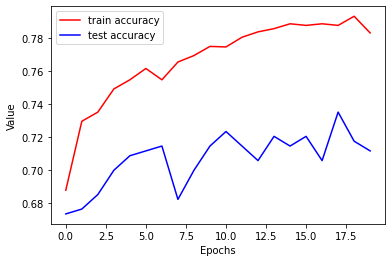

<Figure size 432x288 with 0 Axes>

In [41]:
plt.plot(res_dict["train_acc_list"], c="red", label="train accuracy")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()

plt.plot(res_dict["test_acc_list"], c="blue", label="test accuracy")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.savefig('acc-epochs.png')
plt.show()
plt.clf()


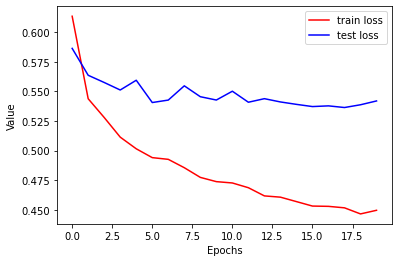

In [42]:
plt.plot(res_dict["train_loss_list"], c="red", label="train loss")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()

plt.plot(res_dict["test_loss_list"], c="blue", label="test loss")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.savefig('loss-epochs.png')
plt.show()

In [43]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sn
softmax = nn.Softmax()

positive_probs = np.array([])
negative_probs = np.array([])
conv_conf_mat = np.zeros((2,2))
name_labels=[x for x in range(2)]
for batch in tqdm(test_dataloader):        
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
            logits = model(b_input_ids, b_attn_mask)
            probs = softmax(logits).detach().numpy()
            positive_probs = np.hstack([positive_probs, probs[:,1]])
            negative_probs = np.hstack([negative_probs, probs[:,0]])
            predictions = torch.argmax(logits, dim = 1)
            conv_conf_mat += confusion_matrix(b_labels.numpy(), predictions.numpy(), labels=name_labels)

conv_df_cm = pd.DataFrame(conf_mat, index = [i for i in ["not complain", "complain"]],
columns = [i for i in ["not complain", "complain"]])

  0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-43-3887aa344c71>:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = softmax(logits).detach().numpy()
100%|██████████| 11/11 [00:19<00:00,  1.73s/it]


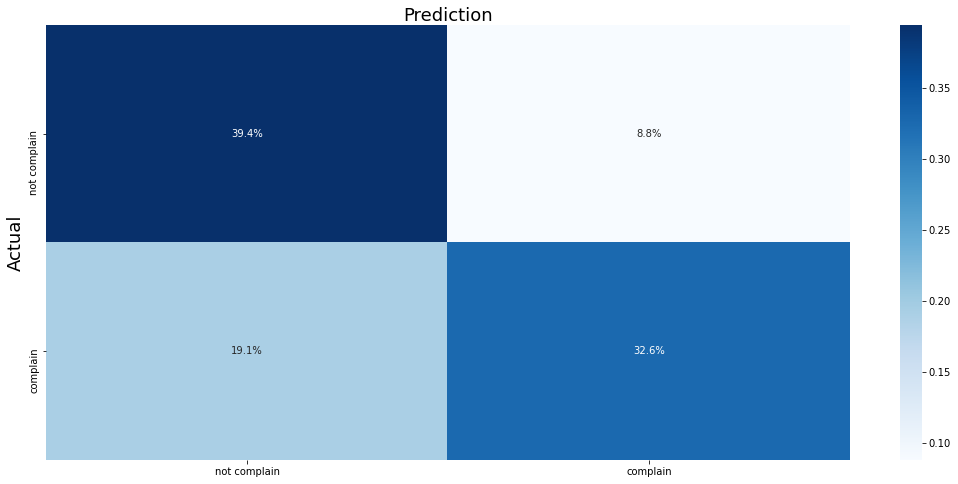

In [44]:
fig, ax = plt.subplots(figsize=(18, 8))

sn.heatmap(df_cm/np.sum(conf_mat), annot=True, 
            fmt='.1%', cmap='Blues')
ax.set_ylabel('Actual', fontsize=18)    
ax.set_xlabel('Prediction', fontsize=18)    
ax.xaxis.set_label_position('top') 


In [25]:
test_tweets_converted = [x[0] for x in test_tweets_converted]

In [45]:
converted_test_inputs, converted_test_masks = preprocessing_for_bert(test_tweets_converted)
converted_test_data = TensorDataset(converted_test_inputs, converted_test_masks, test_labels)
converted_test_sampler = SequentialSampler(converted_test_data)
converted_test_dataloader = DataLoader(converted_test_data, sampler=converted_test_sampler, batch_size=batch_size)

In [46]:
softmax = nn.Softmax()

converted_positive_probs = np.array([])
converted_negative_probs = np.array([])
conv_conf_mat = np.zeros((2,2))
name_labels=[x for x in range(2)]
for batch in tqdm(converted_test_dataloader):        
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
            logits = model(b_input_ids, b_attn_mask)
            probs = softmax(logits).detach().numpy()
            converted_positive_probs = np.hstack([converted_positive_probs, probs[:,1]])
            converted_negative_probs = np.hstack([converted_negative_probs, probs[:,0]])
            predictions = torch.argmax(logits, dim = 1)
            conv_conf_mat += confusion_matrix(b_labels.numpy(), predictions.numpy(), labels=name_labels)

conv_df_cm = pd.DataFrame(conf_mat, index = [i for i in ["not complain", "complain"]],
columns = [i for i in ["not complain", "complain"]])

  0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-46-c15906c77c1a>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = softmax(logits).detach().numpy()
100%|██████████| 11/11 [00:21<00:00,  1.97s/it]


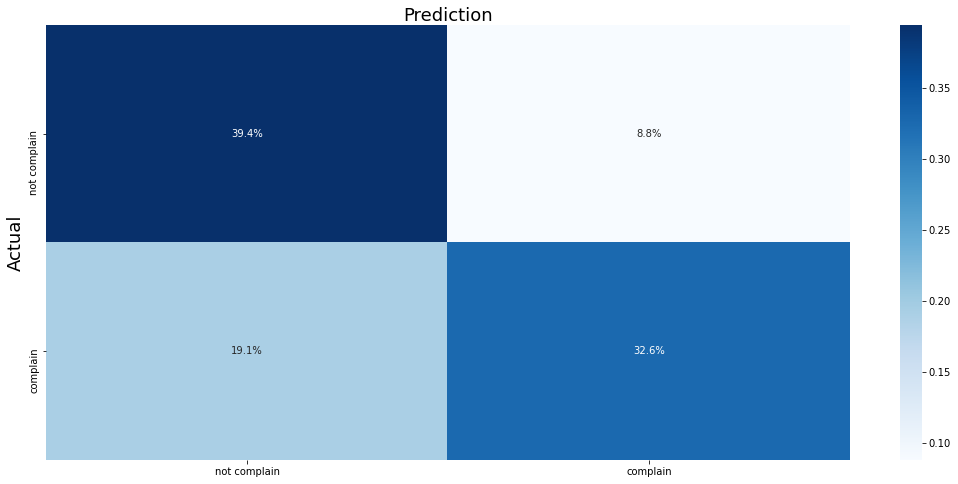

In [47]:
fig, ax = plt.subplots(figsize=(18, 8))

sn.heatmap(df_cm/np.sum(conf_mat), annot=True, 
            fmt='.1%', cmap='Blues')
ax.set_ylabel('Actual', fontsize=18)    
ax.set_xlabel('Prediction', fontsize=18)    
ax.xaxis.set_label_position('top') 

In [48]:
np.mean(positive_probs)
np.mean(negative_probs)


0.450185565321761

In [49]:
sum(weights*(converted_positive_probs - positive_probs))

-0.005406549967375677

In [50]:
np.mean(converted_positive_probs - positive_probs)

-0.009527279243475812

In [51]:
sum(weights*(converted_negative_probs - negative_probs))

0.00540654878897866

In [52]:
np.std(weights*(converted_positive_probs - positive_probs))

0.0010403055864517644